In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: remove '..' if run from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot'), os.path.join(home, 'astrobot', 'tests')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot import pmf

import numpy as np 
import pandas as pd
from pprint import pprint 
import matplotlib.pyplot as plt 
from functools import reduce 

def pp(x, *args): 
    pprint(x) if not args else (pprint(x), pp(*args))


In [2]:
# bldg_stock namespace
def get_osm_url(bldg_id, zero_pad=7):
    zeros = reduce(
        lambda a, b: str(a)+"0", range(zero_pad - int(np.log10(bldg_id) + 1)))
    return ("https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/" +  "end-use-load-profiles-for-us-building-stock/2021/" +
            "comstock_tmy3_release_1/building_energy_models/" + 
            "bldg{}-up00.osm.gz".format(zeros + str(bldg_id)))
            
DATADIR = "C:/users/admin/master/astrobot/resources/rescomstock/resstock"
assert os.path.isdir(DATADIR)
metacom_fpath = os.path.join(DATADIR, "metadata_resstock.tsv")
_comdf = pd.read_csv(metacom_fpath, sep='\t')
_comdf = _comdf.dropna(axis=0, how="any")
_comdf.head(2)

,bldg_id,in.county,in.puma,in.ashrae_iecc_climate_zone_2004,in.building_america_climate_zone,in.iso_rto_region,applicability,weight,in.sqft,in.ahs_region,...,out.propane.total.energy_consumption,out.propane.total.energy_consumption_intensity,out.wood.total.energy_consumption,out.wood.total.energy_consumption_intensity,out.wood.heating.energy_consumption,out.wood.heating.energy_consumption_intensity,out.site_energy.total.energy_consumption,out.site_energy.total.energy_consumption_intensity,upgrade,metadata_index
0,1,G5100230,G51051045,4A,Mixed-Humid,PJM,True,242.131013,1623.0,Non-CBSA South Atlantic,...,0.0,0.0,0.0,0.0,0.0,0.0,39404.872841,24.279034,0,0
1,2,G5600250,G56000400,6B,Cold,None,True,242.131013,617.0,Non-CBSA Mountain,...,0.0,0.0,0.0,0.0,0.0,0.0,26635.835447,43.169912,0,1


In [7]:
def search_comdf_var(var):
    return [col for col in _comdf.columns if var.lower() in col.lower()]

search_comdf_var("in.")
#set(_comdf["in.building_type"])
#_comdf[["metadata_index", "bldg_id"]]
lbl_cz = 'in.ashrae_iecc_climate_zone_2004'
lbl_mf = 'in.geometry_building_type_recs'
_comdf[[lbl_cz, lbl_mf]].head()

,in.ashrae_iecc_climate_zone_2004,in.geometry_building_type_recs
0,4A,Multi-Family with 5+ Units
1,6B,Multi-Family with 2 - 4 Units
2,3A,Multi-Family with 5+ Units
3,2A,Multi-Family with 2 - 4 Units
4,4A,Single-Family Attached


In [3]:
comdf = _comdf.copy()
# pp([c for c in _comdf.columns if "in." in c])

y_lbls = ["eui"] 
X_lbls = ["cz_cat", "cz", "btype_cat", "btype", "weight", "metadata_index", "bldg_id"] 
comdf[["cz_cat", "btype_cat"]] = comdf[["in.ashrae_iecc_climate_zone_2004", "in.geometry_building_type_recs"]]
_kwh_arr, _sqft_arr = comdf["out.site_energy.total.energy_consumption"], comdf["in.sqft"]
comdf[y_lbls[0]] = _kwh_arr / (_sqft_arr / 10.764)  # Convert kWh, ft2 -> kWh/m2

# Integer encoding for cz categories
cz_dict = {cz:i for i, cz in enumerate(np.unique(comdf["cz_cat"]))}
comdf["cz"] = [cz_dict[cz] for cz in comdf["cz_cat"]]
 
# Integer encoding for btype
btype_dict = {bt:i for i, bt in enumerate(np.unique(comdf["btype_cat"]))}
comdf["btype"] = [btype_dict[bt] for bt in comdf["btype_cat"]]

comdf = comdf[X_lbls + y_lbls]
comdf.head(5)


,cz_cat,cz,btype_cat,btype,weight,metadata_index,bldg_id,eui
0,4A,6,Multi-Family with 5+ Units,2,242.131013,0,1,261.339526
1,6B,12,Multi-Family with 2 - 4 Units,1,242.131013,1,2,464.680928
2,3A,3,Multi-Family with 5+ Units,2,242.131013,2,3,309.696571
3,2A,1,Multi-Family with 2 - 4 Units,1,242.131013,3,4,140.524085
4,4A,6,Single-Family Attached,3,242.131013,4,5,62.699874


In [4]:
print(_comdf.shape)
print(_comdf.weight.sum())

from tests.pmf_test import test_make_pmf, test_make_bin_idx, test_make_bin_edges
from tests.pmf_test import test_make_joint_pmf 

from scipy.stats._binned_statistic import binned_statistic
pd.set_option("display.precision", 6)

test_make_bin_edges()
test_make_bin_idx()
test_make_pmf()

test_make_joint_pmf()


(549800, 249)
133123630.79745477


In [6]:
iei_df = pd.read_clipboard()
iei_df["eui"] = iei_df["energy_use_intensity"] / 3.6
iei_df.head(5)


,energy_use_intensity,eui
0,911.043002,253.067501
1,922.115987,256.143330
2,893.753105,248.264751
3,853.440909,237.066919
4,877.564371,243.767881


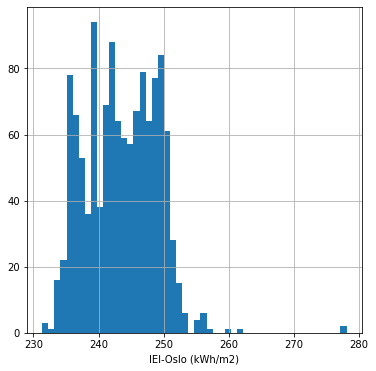

In [23]:
np.warnings.filterwarnings('ignore')
data = comdf.query(
    '"Multi-Family with 5+ Units" in btype_cat & cz > 8')
data.loc[:, "idx"] = np.arange(data.shape[0])
data.set_index("idx")

# Plot the empirical distribution of marginal EUI: sum_ij{ P(eui, btype_i, cz_j) }
bins=50
eui = pmf.Pmf(data.eui, bins, data.weight, id=data.index)
eui_iei = pmf.Pmf(iei_df["eui"], bins);

_, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
#pmf.plt_hist(eui_iei, width=15, ax=ax);
iei_df["eui"].hist(bins=50)
ax.set_xlabel("IEI-Oslo (kWh/m2)");


199.26201928214712


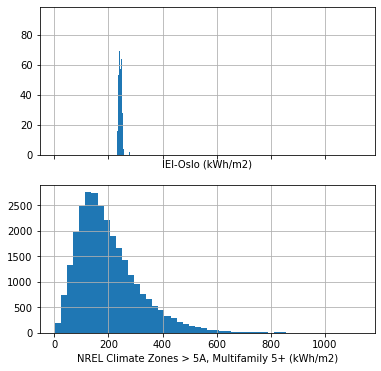

In [28]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
data["eui"].hist(bins=50, ax=ax[1])
ax[1].set_xlabel("NREL Climate Zones > 5A, Multifamily 5+ (kWh/m2)")
iei_df["eui"].hist(bins=50, ax=ax[0])
ax[0].set_xlabel("IEI-Oslo (kWh/m2)");
pp(data.eui.mean())

In [24]:
iei_df["eui"].describe()

count    1240.000000
mean      243.450409
std         5.394842
min       231.343159
25%       239.406299
50%       243.356000
75%       247.744369
max       278.046899
Name: eui, dtype: float64

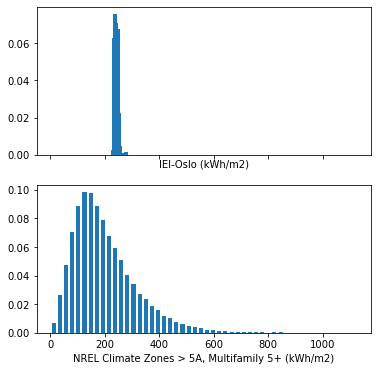

In [21]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
pmf.plt_hist(eui, width=15, ax=ax[1]); 
pmf.plt_hist(eui_iei, width=15, ax=ax[0]);
ax[1].set_xlabel("NREL Climate Zones > 5A, Multifamily 5+ (kWh/m2)")
ax[0].set_xlabel("IEI-Oslo (kWh/m2)");


In [22]:
iei_df["eui"].describe()
# std: 14
# 15 / 255 * 100.0
data.eui.describe()



count    27972.000000
mean       199.262019
std        116.124637
min          2.037850
25%        116.673845
50%        175.370604
75%        257.391520
max       1127.059293
Name: eui, dtype: float64

In [8]:
"""
- Goal: Show stairstep?
- Goal: Show forward/inverse prob. models?
- Eval: Show prediction accuracy by testing on validation set. 
"""
theta = "epd"
X = ["cz", "vintage", "btype"]
y = "eui"
evidence = {"eui":[25, 50, 75], "cz":"4B", "vintage":"pst80s", "btype":"LargeOffice"}

# Infer parameter epd from y, X

# Construct data according to Pyro
dag = DAG(data=compdf)  

# Model joint and marginal probability of p(X, eui)
for varx in X: 
    epd_eui_pmf = prob_joint(varx, "eui", dag=dag)
    m1, m2 = prob_marginal(varx, dag=dag), prob_marginal("eui", dag=dag)
    plt_hist3(epd_eui_pmf, m1, m2)
    
# Forward modeling (p(y=[25,50,75]|X,theta)) ??
for x in X: 
    eui_pmf = prob_cond(prior="eui", likelihood=5, marginal=5)

# Model inverse p(X=epd | eui=[25, 50, 75])
for eui_pctile in [25, 50, 75]:
    epd_pmf = prob_cond(prior"epd", likelihood=likelihood, marginal="eui", dag=dag)
    plt_hist(epd_pmf)
    info_metric = cond_entropy(epd_pmf)  # how much info obtained about epd given eui
    print(info_metric)



SyntaxError: invalid syntax (Temp/ipykernel_8960/3668422546.py, line 28)

In [ ]:
# TODO: 
# Xclean up function: _make_joint_pmf(data) 
# Xtest _make_joint_pmf(data)
# XJointPmf(dataset) -> df w/ multiindex
# write: margin_pmf(joint_pmf) -> Pmf
# test p(x, y) = p(x) & p(y) = p(x) p(x|y) = p(y) p(y|x)
# plot joint of eui and cz (same as query)
# write cond_pmf
# p(e,cz,v) = p(e|cz,v) p(cz|v) p(v) 


In [ ]:
from scipy.stats import binned_statistic 

# Flip two coins, probability of state = 2^2 = 4 states:
# Joint pmf is:
# [Hx_Hy, Hy_Tx]
# [Tx_Hy, Ty_Tx]
pxy = np.array(
  # y1: H, x2:T
    [[.25, .25],  # x1: H 
     [.25, .25]]) # x2: T
# p(x, y) = p(x) & p(y) = p(x) p(x|y) = p(y) p(y|x) 
# Marginalize ith x row by:
# 1. Summing joint through all j cols 
# 2. Normalize with factor p(x_ij) = 1 / sum_ij( p(x_ij, y_ij))    
# p(x_i=1) = sum_j p(x_i=1, y_j) 
#px = 1 / np.sum([xy_ij for x_i in pxy for xy_ij in x_i])
px_i = np.array([[np.sum(x_i)] for x_i in pxy])
# pp(px_i)
# For py iterate through column space
py_i = np.array([[np.sum(y_j)] for y_j in pxy.T]).T
# pp(py_i)
